In [2]:
from pathlib import Path
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
from cmbml.utils.physics_mask import downgrade_mask
from cmbml.core.asset_handlers import HealpyMap
# from cmbml.utils.physics_mean_inpaint import inpaint_with_neighbor_mean
import matplotlib.pyplot as plt

In [32]:
DEFAULT_UNIT = u.uK_RJ  # An aspect of PySM3; can be changed if using pysm3.Sky instead
OUTPUT_UNIT = u.uK_CMB

NSIDE = 128

In [33]:
nilc_mask_fn = Path("/bigdata/cmb_project/data/Assets/Planck/COM_CMB_IQU-nilc_2048_R3.00_full.fits")
big_mask = hp.read_map(nilc_mask_fn, field=3)
MASK = downgrade_mask(big_mask, nside_out=NSIDE, threshold=0.9)
MASK = np.logical_not(MASK)
del big_mask

In [34]:
BASE_DUST = pysm3.ModifiedBlackBody(
    nside=NSIDE,
    map_I = "dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits",
    map_mbb_index = 1.48,
    map_mbb_temperature = 19.6,
    unit_mbb_temperature = "K",
    freq_ref_I = "353 GHz",
    freq_ref_P = "353 GHz"
)

In [37]:
DEFAULT_MBB_TEMP = BASE_DUST.mbb_temperature
DEFAULT_MBB_IDX = BASE_DUST.mbb_index

19881 uK_CMB


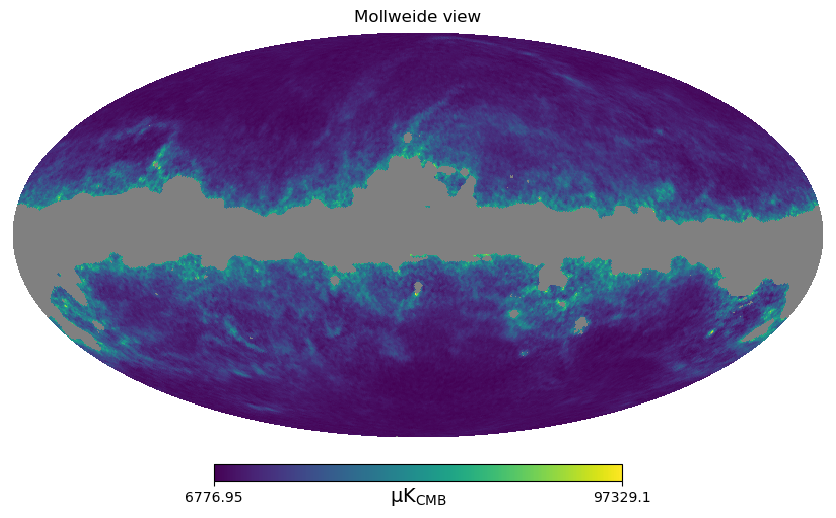

In [38]:
USE_FREQ = 545 * u.GHz

# Get emission
base_dust_out = BASE_DUST.get_emission(USE_FREQ)

# Get only temperature field
base_dust_out = base_dust_out[0]

# Convert unit (PySM3 Sky is always uK_RJ; we've discussed things in uK_CMB)
eq = u.cmb_equivalencies(USE_FREQ)
base_dust_out = base_dust_out.to(OUTPUT_UNIT,
                                 equivalencies=eq)

# Apply mask
base_dust_out = hp.ma(base_dust_out)
base_dust_out.mask = MASK

# Get mean temperature
base_dust_pxs = base_dust_out.compressed()
sim_mean_masked_temp = u.Quantity(np.mean(base_dust_pxs), OUTPUT_UNIT)
print(f"{sim_mean_masked_temp:.0f}")

# Show masked map
hp.mollview(base_dust_out, unit=OUTPUT_UNIT.to_string('latex_inline'))

## Function to get mean temp

In [39]:
def get_sim_temp_w_params(freq, temp, idx):
    BASE_DUST.mbb_index = idx
    BASE_DUST.mbb_temperature = temp

    # Get emission
    base_dust_out = BASE_DUST.get_emission(freq)

    # Get only temperature field
    base_dust_out = base_dust_out[0]

    # Convert unit (PySM3 Sky is always uK_RJ; we've discussed things in uK_CMB)
    eq = u.cmb_equivalencies(freq)
    base_dust_out = base_dust_out.to(OUTPUT_UNIT,
                                     equivalencies=eq)

    # Apply mask
    base_dust_out = hp.ma(base_dust_out)
    base_dust_out.mask = MASK

    # Get mean temperature
    base_dust_pxs = base_dust_out.compressed()
    result = u.Quantity(np.mean(base_dust_pxs), OUTPUT_UNIT)
    return result

In [40]:
fn_temp = get_sim_temp_w_params(freq=USE_FREQ,
                                temp=DEFAULT_MBB_TEMP,
                                idx=DEFAULT_MBB_IDX)
assert fn_temp == sim_mean_masked_temp, "Uh oh! Something changed!"

## Get Planck stuff

In [41]:
ORIG_PLANCK_FNS = {
            30 : "LFI_SkyMap_030-BPassCorrected_1024_R3.00_full.fits",
            44 : "LFI_SkyMap_044-BPassCorrected_1024_R3.00_full.fits",
            70 : "LFI_SkyMap_070-BPassCorrected_1024_R3.00_full.fits",
            100: "HFI_SkyMap_100_2048_R3.01_full.fits",
            143: "HFI_SkyMap_143_2048_R3.01_full.fits",
            217: "HFI_SkyMap_217_2048_R3.01_full.fits",
            353: "HFI_SkyMap_353-psb_2048_R3.01_full.fits",
            545: "HFI_SkyMap_545_2048_R3.01_full.fits",
            857: "HFI_SkyMap_857_2048_R3.01_full.fits",
        }
ORIG_PLANCK_DIR = "/bigdata/cmb_project/data/Assets/Planck/"  # Change the directory as needed.

def get_planck_fn(freq):
    fns = ORIG_PLANCK_FNS
    planck_dir = ORIG_PLANCK_DIR
    return Path(planck_dir) / fns[freq.value]

def get_map(fn, freq, nside, unit=None):
    if unit is None:
        raise ValueError("Must specify unit when loading map.")
    h = HealpyMap()
    m = h.read(fn)[0]
    # print(f"Sim source unit is {m.unit}")
    # m = inpaint_with_neighbor_mean(m, max_iters=5)
    
    # hp.ud_grade is not to be trusted generally, but it's fast and cheap. Justify when used.
    m_unit = m.unit  # Need to preserve units; hp.ud_grade isn't compatible
    m = m.value
    m = hp.ud_grade(m, nside_out=nside)  # We don't care about power spectra; 
                                         #   just want an approximate mean temp.
    m = u.Quantity(m, m_unit)
    
    # Convert unit
    m = m.to(unit,
             equivalencies=u.cmb_equivalencies(freq))
    return m

19939 uK_CMB


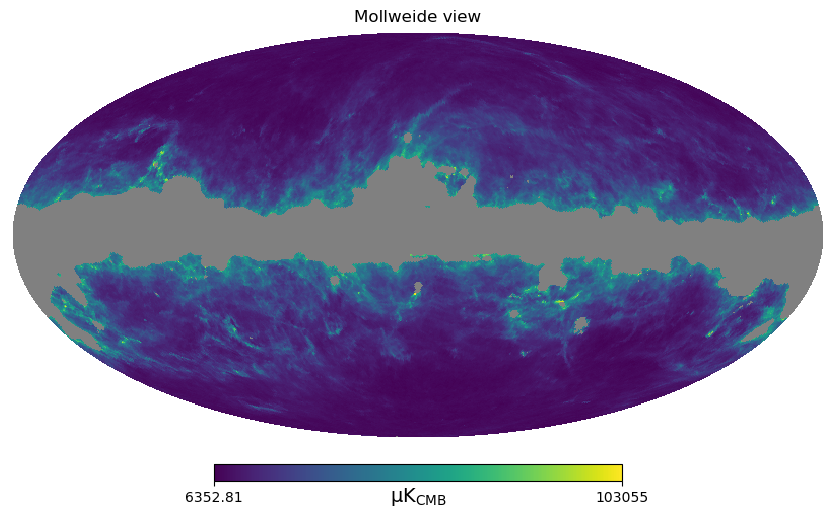

In [42]:
USE_FREQ = 545 * u.GHz

# Get Planck map
planck_test_fn = get_planck_fn(USE_FREQ)
planck_test_map = get_map(planck_test_fn,
                          freq=USE_FREQ,
                          nside=NSIDE,
                          unit=OUTPUT_UNIT)

# Apply mask
planck_test_map = hp.ma(planck_test_map)
planck_test_map.mask = MASK

# Get mean temperature
planck_test_pxs = planck_test_map.compressed()
pl_mean_masked_temp = u.Quantity(np.mean(planck_test_pxs), OUTPUT_UNIT)
print(f"{pl_mean_masked_temp:.0f}")

# Show masked map
hp.mollview(planck_test_map, unit=OUTPUT_UNIT.to_string('latex_inline'))

## Plank temp value

In [43]:
def get_target_temp_planck(freq, nside=NSIDE):
    # Get Planck map
    planck_test_fn = get_planck_fn(freq)
    planck_test_map = get_map(planck_test_fn,
                              freq=freq,
                              nside=nside,
                              unit=OUTPUT_UNIT)

    # Apply mask
    planck_test_map = hp.ma(planck_test_map)
    planck_test_map.mask = MASK

    # Get mean temperature
    planck_test_pxs = planck_test_map.compressed()
    mean_masked_temp = u.Quantity(np.mean(planck_test_pxs), OUTPUT_UNIT)

    return mean_masked_temp

In [44]:
assert get_target_temp_planck(USE_FREQ) == pl_mean_masked_temp, "Oh no! Something changed"

## Get temperature values

In [ ]:
def produce_figure(freq, temp_vals, idx_vals, n_traces):
    target = get_target_temp_planck(freq).value
    res_temps = {}
    for i in idx_vals:
        for t in temp_vals:
            new_temp = get_sim_temp_w_params(freq=freq,
                                            temp=t,
                                            idx=i)
            res_temps[(i, t)] = new_temp

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # --- First subplot: vary temperature at fixed index ---
    ax = axes[0]
    ax.axhline(target, color="black", lw=0.5, label="Planck mean temp")
    for i, idx in enumerate(idx_vals):
        if i % (len(idx_vals) // n_traces) != 0:
            continue
        this_series = np.array(
            [res_temps[idx, t].value for t in temp_vals]
        )
        ax.plot(temp_vals, this_series, lw=0.5, label=f"MBB index: {idx:.2f}")
    ax.axvline(DEFAULT_MBB_TEMP.value, lw=0.5, color="red", ls=':', 
               label=f"Default temp: {DEFAULT_MBB_TEMP}")
    ax.set_ylabel(f"Mean masked temperature [{OUTPUT_UNIT.to_string('latex_inline')}]")
    ax.set_xlabel(r"Modified Black Body Temperature [$\mathrm{K}$]")
    ax.set_title(f"{freq} – Varying Temp")
    ax.legend()

    # --- Second subplot: vary index at fixed temperature ---
    ax = axes[1]
    ax.axhline(target, color="black", lw=0.5, label="Planck mean temp")
    for j, temp in enumerate(temp_vals):
        if j % (len(temp_vals) // n_traces) != 0:
            continue
        this_series = np.array(
            [res_temps[i, temp].value for i in idx_vals]
        )
        ax.plot(idx_vals, this_series, lw=0.5, label=f"MBB temp: {temp:.2f}")
    ax.axvline(DEFAULT_MBB_IDX, lw=0.5, color="red", ls=':', 
               label=f"Default index: {DEFAULT_MBB_IDX}")
    ax.set_xlabel(r"Modified Black Body Spectral Index [Unitless]")
    ax.set_title(f"{freq} – Varying Index")
    ax.legend()

    plt.tight_layout()
    plt.show()


In [54]:
N_VALS = 50
N_TRACES = 10
MBB_TEMPS = np.linspace(start=DEFAULT_MBB_TEMP*0.5,
                        stop=DEFAULT_MBB_TEMP*1.5,
                        num=N_VALS)
MBB_INDCS = np.linspace(start=DEFAULT_MBB_IDX*0.5,
                        stop=DEFAULT_MBB_IDX*1.5,
                        num=N_VALS)

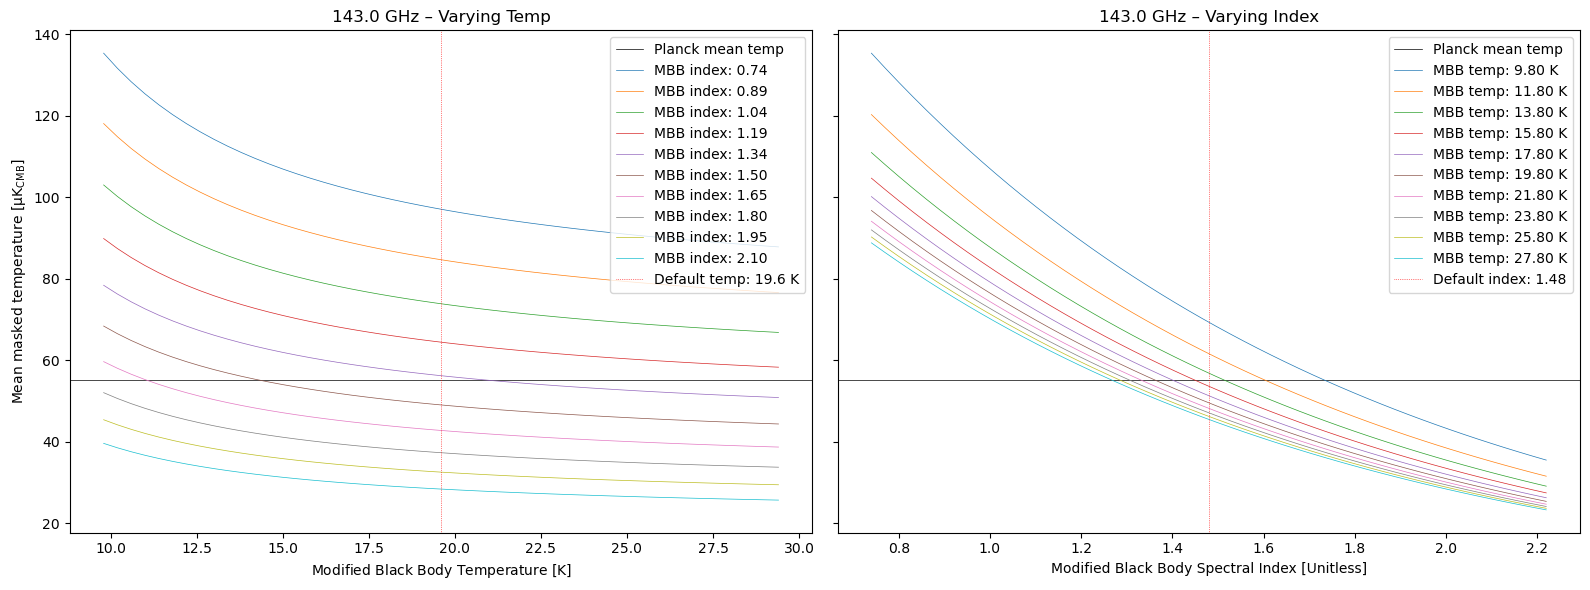

In [55]:
produce_figure(143*u.GHz, MBB_TEMPS, MBB_INDCS, N_TRACES)


##

### 3D plot 

In [57]:
freq = 143
target = get_target_temp_planck(freq*u.GHz).value
target

55.235718

In [ ]:
res_temps=np.zeros((len(MBB_INDCS), len(MBB_TEMPS)))
for i_idx, i in enumerate(MBB_INDCS):
    for t_idx, t in enumerate(MBB_TEMPS):
        new_temp = get_sim_temp_w_params(freq=freq*u.GHz,
                                        temp=t,
                                        idx=i)
        res_temps[i_idx, t_idx] = new_temp.value

In [ ]:
print(res_temps.shape)

(50, 50)


In [63]:
res_temps

array([[135.36307599, 131.65823272, 128.35454374, ...,  88.31645964,
         88.07279008,  87.83678036],
       [131.71855726, 128.11346328, 124.8987229 , ...,  85.93862514,
         85.70151616,  85.47186076],
       [128.17216364, 124.6641333 , 121.53594667, ...,  83.62481152,
         83.39408646,  83.17061432],
       ...,
       [ 37.5316351 ,  36.50440649,  35.58840448, ...,  24.48718835,
         24.41962696,  24.35418939],
       [ 36.52113245,  35.52156096,  34.63022141, ...,  23.82789469,
         23.76215234,  23.69847661],
       [ 35.5378366 ,  34.5651776 ,  33.6978365 , ...,  23.18635188,
         23.12237957,  23.06041825]])

In [59]:
T, I = np.meshgrid(MBB_TEMPS.value, MBB_INDCS.value)
Z = res_temps

print(T.shape, I.shape, Z.shape)

(50, 50) (50, 50) (50, 50)


In [62]:
Z

array([[135.36307599, 131.65823272, 128.35454374, ...,  88.31645964,
         88.07279008,  87.83678036],
       [131.71855726, 128.11346328, 124.8987229 , ...,  85.93862514,
         85.70151616,  85.47186076],
       [128.17216364, 124.6641333 , 121.53594667, ...,  83.62481152,
         83.39408646,  83.17061432],
       ...,
       [ 37.5316351 ,  36.50440649,  35.58840448, ...,  24.48718835,
         24.41962696,  24.35418939],
       [ 36.52113245,  35.52156096,  34.63022141, ...,  23.82789469,
         23.76215234,  23.69847661],
       [ 35.5378366 ,  34.5651776 ,  33.6978365 , ...,  23.18635188,
         23.12237957,  23.06041825]])

In [65]:
intersection_mask = Z - target 
intersection_mask

array([[ 80.12735822,  76.42251495,  73.11882596, ...,  33.08074186,
         32.83707231,  32.60106259],
       [ 76.48283949,  72.87774551,  69.66300513, ...,  30.70290737,
         30.46579838,  30.23614299],
       [ 72.93644587,  69.42841553,  66.30022889, ...,  28.38909375,
         28.15836869,  27.93489655],
       ...,
       [-17.70408267, -18.73131129, -19.6473133 , ..., -30.74852943,
        -30.81609081, -30.88152838],
       [-18.71458532, -19.71415681, -20.60549636, ..., -31.40782308,
        -31.47356544, -31.53724117],
       [-19.69788117, -20.67054018, -21.53788128, ..., -32.04936589,
        -32.1133382 , -32.17529952]])

In [66]:
t_idx, i_idx = np.where(np.abs(intersection_mask) < 1e-2)

In [67]:
intersection_points = [(MBB_TEMPS[t].value, MBB_INDCS[i].value) for t, i in zip(t_idx, i_idx)]
intersection_points

[(16.6, 2.2199999999999998), (17.0, 1.9481632653061223)]

In [68]:
%matplotlib widget
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#gpt code to put everything together
def produce_figure_3d_plotly(freq, temp_vals, idx_vals):
    target = get_target_temp_planck(freq).value
    
    res_temps = np.zeros((len(idx_vals), len(temp_vals)))
    for i_idx, i in enumerate(idx_vals):
        for t_idx, t in enumerate(temp_vals):
            new_temp = get_sim_temp_w_params(freq=freq, temp=t, idx=i)
            res_temps[i_idx, t_idx] = new_temp.value

    Z = res_temps
    
    # find intersection points
    tolerance = 0.2
    intersection_mask = np.abs(Z - target) < tolerance
    t_idx, i_idx = np.where(intersection_mask)
    temp_vals_list = [t.value for t in temp_vals]
    idx_vals_list  = [i.value for i in idx_vals]
    intersection_points = [(temp_vals_list[t], idx_vals_list[i]) for t, i in zip(t_idx, i_idx)]
    
    intersection_points_rounded = [(round(t, 2), round(i, 2)) for t, i in intersection_points]
    print("Intersection points (T, I):", intersection_points_rounded)


    # Meshgrid
    T, I = np.meshgrid(temp_vals_list, idx_vals_list)
    
    fig = go.Figure(data=[
        go.Surface(x=T, y=I, z=Z, colorscale="Viridis", name="Simulation"),
        go.Surface(x=T, y=I, z=target*np.ones_like(Z), colorscale=[[0, "black"], [1, "black"]],
                   opacity=0.4, showscale=False, name="Planck mean")
    ])

    fig.update_layout(
        scene=dict(
            xaxis_title="MBB Temperature [K]",
            yaxis_title="MBB Index",
            zaxis_title=f"Mean masked temp [{OUTPUT_UNIT.to_string()}]"
        ),
        title=f"{freq} GHz Simulation vs Planck"
    )

    
    fig.update_layout(
        width=900,   # figure width in pixels
        height=700,  # figure height in pixels
        scene=dict(
            xaxis_title="MBB Temperature [K]",
            yaxis_title="MBB Index",
            zaxis_title=f"Mean masked temp [{OUTPUT_UNIT.to_string()}]",
            zaxis=dict(
                range=[Z.min()*0.95, Z.max()*1.05]  # expand z-axis a bit
            ),
            xaxis=dict(range=[T.min(), T.max()]),
            yaxis=dict(range=[I.min(), I.max()])
        ),
        title=f"{freq} GHz Simulation vs Planck"
    )
    fig.show()


### Test for all freq: 30, 44, 70, 100, 143, 217, 353, 545, 857

In [18]:
produce_figure_3d_plotly(143*u.GHz, MBB_TEMPS, MBB_INDCS)

Intersection points (T, I): [(16.6, 2.19), (16.6, 2.22), (17.0, 1.92), (17.0, 1.95), (17.0, 1.98), (17.4, 1.74), (17.8, 1.56), (17.8, 1.59), (18.2, 1.43), (18.6, 1.31), (19.0, 1.22), (19.8, 1.07), (20.2, 1.01), (21.8, 0.83), (22.2, 0.8)]


In [19]:
produce_figure_3d_plotly(30*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(44*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(70*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(100*u.GHz, MBB_TEMPS, MBB_INDCS)

Intersection points (T, I): []


Intersection points (T, I): []


Intersection points (T, I): [(10.6, 2.01), (10.6, 2.04), (11.0, 1.71), (11.0, 1.74), (11.4, 1.5), (11.4, 1.53), (11.8, 1.34), (12.2, 1.22), (12.6, 1.1), (13.4, 0.95), (13.8, 0.89), (14.2, 0.83), (15.0, 0.74)]


Intersection points (T, I): [(15.8, 1.95), (15.8, 1.98), (15.8, 2.01), (16.2, 1.71), (16.2, 1.74), (16.2, 1.77), (16.6, 1.53), (16.6, 1.56), (17.0, 1.37), (17.0, 1.4), (17.4, 1.25), (17.4, 1.28), (17.8, 1.16), (18.2, 1.07), (18.6, 1.01), (19.0, 0.95), (19.4, 0.89), (20.2, 0.8), (20.6, 0.77)]


In [20]:
produce_figure_3d_plotly(217*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(353*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(545*u.GHz, MBB_TEMPS, MBB_INDCS)
produce_figure_3d_plotly(857*u.GHz, MBB_TEMPS, MBB_INDCS)

Intersection points (T, I): [(13.4, 2.16), (13.8, 1.95), (14.2, 1.77), (15.4, 1.4), (15.8, 1.31), (17.8, 1.01), (19.0, 0.89), (20.2, 0.8)]


Intersection points (T, I): []


Intersection points (T, I): []


Intersection points (T, I): []
